In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Get_groups import phase_diagram,make_meanr

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import parmap
from pprint import pprint

In [685]:
seed =10
N = 1000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 4
dt = 0.1
t = np.arange(0,10000,dt)
K = 5
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
# plt.plot(np.sort(avg_dtheta[-1]))
# plt.plot((avg_dtheta[-1]))

(1.0, 827.4)

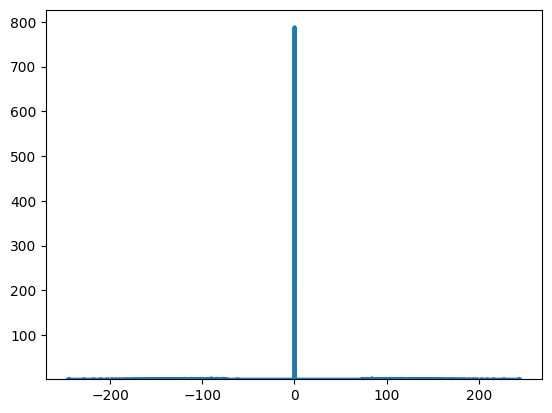

In [686]:
th = ((theta[-1] - theta[-5000] )//(np.pi*2))
c,b = np.histogram(th,bins=3000)
plt.plot(b[1:],c,lw=3)
plt.ylim(1,)

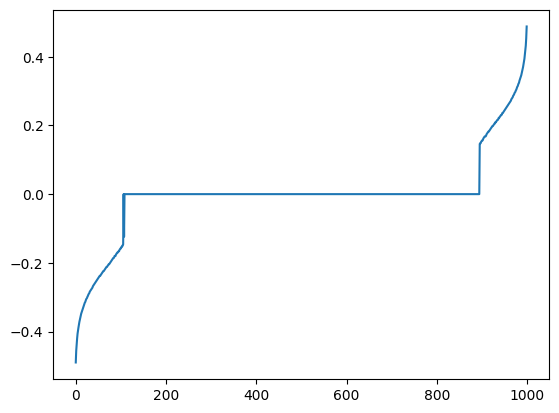

In [718]:
plt.plot((theta[-1] -  theta[-5000])//(np.pi*2)/500)

In [688]:
def Get_Group(TH_s,TH_e,L,dt):
    ARG = (TH_s-TH_e)//(2*np.pi)
    ARG =  np.where(ARG<0,ARG,ARG)
    u,c = np.unique(ARG,return_counts=True)

    I_c_o1 =np.where(c>5)
    u_o1 = u[I_c_o1]
    c_o1 = c[I_c_o1]
    u_c = np.argsort(c_o1)[::-1]
    UU = u_o1[u_c]

    arr = UU
    main_value = np.min(abs(arr))
    adjusted_arr = arr - main_value
    abs_arr = np.unique(np.abs(adjusted_arr))
    abs_arr
    group_threshold = 5
    G = {}
    GP = {}
    GM = {}
    GN = {}
    G_num = 0
    GP_num = 1
    GM_num = 1
    I_num = 1
    for i in range(1,5):
        GP[i,'I'] = []
        GP[i,'R'] = np.nan
        GP[i,'L'] = np.nan
        GP[i,'V'] = np.nan
        GM[i,'I'] = []
        GM[i,'R'] = np.nan
        GM[i,'L'] = np.nan
        GM[i,'V'] = np.nan
    for i in range(5):
        abs_arr = np.unique(np.abs(adjusted_arr))
        for num in abs_arr:
            abs_adjust_arr = np.abs(adjusted_arr)
            in_group = np.int64(np.round((abs_adjust_arr-num)/group_threshold)) * group_threshold
            is_group = np.where(abs(in_group) < 1)
            not_group = np.where(in_group >= 1)
            if len(is_group) != 0:
                Ra_arr = adjusted_arr[is_group]
                R = Ra_arr + main_value
                if G_num == 0:
                    I, = np.where(np.isin(ARG,R))
                    G[G_num,'I'] = I
                    G[G_num,'R'] = R
                    G[G_num,'L'] = len(I)
                    G[G_num,'V'] = np.mean(R/(L-1)/dt)
                    G_num +=1
                else:
                    gp_idx, = np.where(Ra_arr>0)
                    gm_idx, = np.where(Ra_arr<0)
                    Rp = R[gp_idx]
                    Rm = R[gm_idx]
                    Ip, = np.where(np.isin(ARG,Rp))
                    Im, = np.where(np.isin(ARG,Rm))
                    if (len(Rp) !=0) and (len(Rm) != 0):
                        GM[GM_num,'I'] = Im
                        GM[GM_num,'R'] = Rm
                        GM[GM_num,'V'] = np.mean(Rm/(L-1)/dt)
                        GM[GM_num,'L'] = len(Im)
                        GP[GP_num,'I'] = Ip
                        GP[GP_num,'R'] = Rp
                        GP[GP_num,'V'] = np.mean(Rp/(L-1)/dt)
                        GP[GP_num,'L'] = len(Ip)
                        GP_num += 1
                        GM_num += 1
                    elif (len(Rp) !=0):
                        GP[GP_num,'I'] = Ip
                        GP[GP_num,'R'] = Rp
                        GP[GP_num,'L'] = len(Ip)
                        GP[GP_num,'V'] = np.mean(Rp/(L-1)/dt)

                        GP_num += 1
                    else:
                        GM[GM_num,'I'] = Im
                        GM[GM_num,'R'] = Rm
                        GM[GM_num,'L'] = len(Im)
                        GM[GM_num,'V'] = np.mean(Rm/(L-1)/dt)

                        GM_num += 1

            adjusted_arr = adjusted_arr[not_group]
            break
    return G,GM,GP

In [689]:
def get_OP(r,K,m):
    O1 = 4/np.pi * np.sqrt(K*r/m)
    O2 = 0.3056 * np.sqrt(1/ (K*r*m**3))
    return O1# - O2

def get_Sig_r(r0,rp,K,m):
    OPs = get_OP(r0,K,m)
    mmOO = m**2*OPs**2
    Sig = 2*rp*np.sqrt(1/2 - m*K*r0/(4*(4*mmOO+1)) - (m*K*r0/(2*(mmOO+1)))**2)
    return Sig
                       

def get_rp(r0,sigs,K,m):
    OPs = get_OP(r0,K,m)
    mmOO = m**2*OPs**2
    root = np.sqrt(1/2 - m*K*r0/(4*(4*mmOO+1)) - (m*K*r0/(2*(mmOO+1)))**2)
    rp = sigs/(2*root)
    return rp
                      

In [690]:
TH = 4000
TH_S,TH_E,L = theta[-1],theta[-TH],TH
G,GM,GP = Get_Group(TH_S,TH_E,L,dt =dt)

In [691]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Kuramoto_model import Kuramoto_2nd_mf,Kuramoto_1st_mf
from scipy.stats import norm
from TO_sim.get_cluster import cluster_os_new2
from TO_sim.gen_Distribution import Normal, Quantile_Normal as Q_Normal, Lorentzian
import TO_sim.analytical.order_sec_parameter as OSP
import TO_sim.analytical.sec_order_parameter2 as OSP2
import TO_sim.Integrator_jit as IJ
from tqdm.notebook import tqdm

RK4_jit = IJ.RK4
RK4_jit_short = IJ.RK4_short


class Q_Norm_simul():
    def __init__(self,N,K,m,dt = 0.1,t_end = 5000,seed = 10,start_p = False,g_n=None) -> None:
        '''input : N,K,m,dt. dt, t_end,seed'''
        self.seed = seed
        theta_random, omega, Kc = Q_Normal(N, 0, 1, seed=seed)
        if g_n!=None:
            dist = np.linspace(0,1,N+2)[1:-1]
            omega = g_n(dist)
        omega = np.sort(omega)-np.mean(omega)
        self.N = N; self.K = K; self.m = m;self.dt = dt
        self.t_end = t_end; self.dt = dt
        self.omega = omega
        self.t = np.arange(0, self.t_end+self.dt/2, self.dt)
        Theta = np.zeros(2*N)
        Theta[:N] = theta_random 
        if start_p:
            Theta[N:2*N] = omega
        self.Theta_init = Theta
        self.Theta_ori = Theta
    def solve(self):
        t = self.t
        if self.m == 0:
            func = Kuramoto_1st_mf
        else:
            func = Kuramoto_2nd_mf
            
        sol = RK4_jit(func,self.Theta_init,t, args=(self.omega, self.N, self.m, self.K))
        self.Last_sol = sol[-1]
        N = self.N
        theta,dtheta = sol[:,:N],sol[:,N:2*N]
        rabs = np.mean(np.exp(theta.T*1j),axis=0)
        rs = np.abs(rabs)
        psi = np.angle(rabs)
        if self.dt <0.1:
            t = t[::10]
            theta = theta[::10]
            dtheta = dtheta[::10]
            rs = rs[::10]
            psic = psic[::10]
        self.rs = rs
        self.psi = psi
        self.theta = theta
        self.dtheta = dtheta
        self.Theta_last = sol[-1]
        self.r_mean = np.mean(rs[-500:])
        solution = {}
        solution['rs'] = rs
        solution['psi'] = psi
        solution['r_mean'] = self.r_mean
        solution['r_std'] = np.std(rs[-2000:])
        solution['t'] = t
        solution['theta'] = theta
        solution['dtheta'] = dtheta
        solution['Theta_last'] = sol[-1]
        return solution
    
    def solve_short(self,result_time=2010):
        t = self.t
        if self.m == 0:
            func = Kuramoto_1st_mf
        else:
            func = Kuramoto_2nd_mf
            
        sol = RK4_jit_short(func,self.Theta_init,t, args=(self.omega, self.N, self.m, self.K),result_time=result_time)
        self.Last_sol = sol[-1]
        N = self.N
        theta,dtheta = sol[:,:N],sol[:,N:2*N]
        rabs = np.mean(np.exp(theta.T*1j),axis=0)
        rs = np.abs(rabs)
        psi = np.angle(rabs)
        if self.dt <0.1:
            t = t[::10]
            theta = theta[::10]
            dtheta = dtheta[::10]
            rs = rs[::10]
            psic = psic[::10]

        self.rs = rs
        self.psi = psi
        self.theta = theta
        self.dtheta = dtheta
        self.Theta_last = sol[-1]
        self.r_mean = np.mean(rs[-500:])
        solution = {}
        solution['rs'] = rs
        solution['psi'] = psi
        solution['r_mean'] = self.r_mean
        solution['r_std'] = np.std(rs[-2000:])
        solution['t'] = t
        solution['theta'] = theta
        solution['dtheta'] = dtheta
        solution['Theta_last'] = sol[-1]
        return solution
    

    def get_Group(self,L=2000,Nc=5):
        dt = self.dt
        theta = self.theta
        ARG = (theta[-1]-theta[-L])//np.pi
        avg_dtheta = ARG/(L-1)/dt
        self.avg_dtheta = avg_dtheta
        ARG =  np.where(ARG<0,ARG,ARG)
        u,c = np.unique(ARG,return_counts=True)

        I_c_o1 =np.where(c>Nc)
        u_o1 = u[I_c_o1]
        c_o1 = c[I_c_o1]
        u_c = np.argsort(c_o1)[::-1]
        UU = u_o1[u_c]

        arr = UU
        main_value = np.min(abs(arr))
        adjusted_arr = arr - main_value
        abs_arr = np.unique(np.abs(adjusted_arr))
        abs_arr
        group_threshold = 5
        G = {}
        GP = {}
        GM = {}
        G_num = 0
        GP_num = 1
        GM_num = 1
        for i in range(1,5):
            GP[i,'I'] = [];GP[i,'R'] = np.nan;GP[i,'L'] = np.nan;GP[i,'V'] = np.nan
            GM[i,'I'] = [];GM[i,'R'] = np.nan;GM[i,'L'] = np.nan;GM[i,'V'] = np.nan
        for i in range(5):
            abs_arr = np.unique(np.abs(adjusted_arr))
            for num in abs_arr:
                abs_adjust_arr = np.abs(adjusted_arr)
                in_group = np.int64(np.round((abs_adjust_arr-num)/group_threshold)) * group_threshold
                is_group = np.where(abs(in_group) < 1)
                not_group = np.where(in_group >= 1)
                if len(is_group) != 0:
                    Ra_arr = adjusted_arr[is_group]
                    R = Ra_arr + main_value
                    if G_num == 0:
                        I, = np.where(np.isin(ARG,R))
                        G[G_num,'I'] = I
                        G[G_num,'R'] = R
                        G[G_num,'L'] = len(I)
                        G[G_num,'V'] = np.mean(R/(L-1)/dt)
                        G_num +=1
                    else:
                        gp_idx, = np.where(Ra_arr>0)
                        gm_idx, = np.where(Ra_arr<0)
                        Rp = R[gp_idx]
                        Rm = R[gm_idx]
                        Ip, = np.where(np.isin(ARG,Rp))
                        Im, = np.where(np.isin(ARG,Rm))
                        if (len(Rp) !=0) and (len(Rm) != 0):
                            GM[GM_num,'I'] = Im
                            GM[GM_num,'R'] = Rm
                            GM[GM_num,'V'] = np.mean(Rm/(L-1)/dt)
                            GM[GM_num,'L'] = len(Im)
                            GP[GP_num,'I'] = Ip
                            GP[GP_num,'R'] = Rp
                            GP[GP_num,'V'] = np.mean(Rp/(L-1)/dt)
                            GP[GP_num,'L'] = len(Ip)
                            GP_num += 1
                            GM_num += 1
                        elif (len(Rp) !=0):
                            GP[GP_num,'I'] = Ip
                            GP[GP_num,'R'] = Rp
                            GP[GP_num,'L'] = len(Ip)
                            GP[GP_num,'V'] = np.mean(Rp/(L-1)/dt)
                            GP_num += 1
                        else:
                            GM[GM_num,'I'] = Im
                            GM[GM_num,'R'] = Rm
                            GM[GM_num,'L'] = len(Im)
                            GM[GM_num,'V'] = np.mean(Rm/(L-1)/dt)
                            GM_num += 1
                adjusted_arr = adjusted_arr[not_group]
                break
            self.G = G
            self.GP = GP
            self.GM = GM
        return G,GM,GP

    def get_TMS(self,x,step):
        x_m = np.array([np.mean(x[i:i+step], axis=0) for i in range(len(self.t)-step)])
        x_std = np.array([np.std(x[i:i+step], axis=0) for i in range(len(self.t)-step)])
        return x_m,x_std
    def get_TM(self,x,step):
        x_c = np.cumsum(x,axis=0)
        if x.ndim == 2:
            x_m = (x_c[step:,:] - x_c[:-step,:])/step
        else:
            x_m = (x_c[step:] - x_c[:-step])/step
        return x_m
    def get_R(self,I,step):
        temp = 1/N*np.sum(np.exp(1j*self.theta[:, I]), axis=1)
        if len(I) == 0:
            temp = np.nan*temp
        rc = np.abs(temp)
        psic = np.angle(temp)
        rc_m,rc_std = self.get_TMS(rc,step)
        return rc,psic,rc_m,rc_std
    
    def get_R_last(self,I,sum_time):
        temp = 1/N*np.sum(np.exp(1j*self.theta[-sum_time:, I]), axis=1)
        if len(I) == 0:
            temp = np.nan*temp
        rc = np.abs(temp)
        psic_m = np.mean(np.angle(temp))
        rc_m,rc_std = np.mean(rc),np.std(rc)
        return rc_m,rc_std
            
    def get_r_clu(self,sum_time=500):
        N = self.N
        G,GM,GP = self.get_Group()
        r_info = {}
        rs = self.rs
        psi = self.psi
        rs_mean,rs_std = self.get_TMS(rs,sum_time)
        r_info['tm'] = self.get_TM(self.t,sum_time)
        r_info['T','R'],r_info['T','P'],r_info['T','RM'],r_info['T','RSTD'] = rs,psi,rs_mean,rs_std
        r_info['0','R'],r_info['0','P'],r_info['0','RM'],r_info['0','RSTD'] = self.get_R(G[0,'I'],sum_time)
        for i in range(1,5):
            r_info[f'{i}+','R'],r_info[f'{i}+','P'],r_info[f'{i}+','RM'],r_info[f'{i}+','RSTD'] = self.get_R(GP[i,'I'],sum_time)
            r_info[f'{i}-','R'],r_info[f'{i}-','P'],r_info[f'{i}-','RM'],r_info[f'{i}-','RSTD'] = self.get_R(GM[i,'I'],sum_time)
        return r_info
    
    
    def get_r_clu_last(self,sum_time=500):
        N = self.N
        r_info_last  = {}
        rs = self.rs[-sum_time:]
        psi = self.psi[-sum_time:]
        G,GM,GP = self.get_Group()
        self.G,self.GM,self.GP = G,GM,GP
        rs_mean,rs_std = np.mean(rs),np.std(psi)
        r_info_last['T','RM'],r_info_last['T','RSTD'],r_info_last['T','V'] = rs_mean,rs_std,np.mean(self.avg_dtheta)
        r_info_last['0','RM'],r_info_last['0','RSTD'] = self.get_R_last(G[0,'I'],sum_time)
        r_info_last['0','V'] = G[0,'V']
        LG0 = len(G[0,'I'])
        if LG0 == 0: LG0 = np.nan
        r_info_last['0','S'] = LG0
        for i in range(1,5):
            r_info_last[f'{i}+','RM'],r_info_last[f'{i}+','RSTD'] = self.get_R_last(GP[i,'I'],sum_time)
            r_info_last[f'{i}+','V'] = GP[i,'V']
            LGP = len(GP[i,'I'])
            if LGP == 0: LGP = np.nan
            r_info_last[f'{i}+','S'] = LGP
            
            r_info_last[f'{i}-','RM'],r_info_last[f'{i}-','RSTD'] = self.get_R_last(GM[i,'I'],sum_time)
            r_info_last[f'{i}-','V'] = GM[i,'V']
            LGM = len(GM[i,'I'])
            if LGM == 0: LGM = np.nan
            r_info_last[f'{i}-','S'] = LGM


        clu_name = ['T','0','1+','1-','2+','2-','3+','3-','4+','4-']
        K,m = self.K,self.m
        index = pd.MultiIndex.from_product([[K],[m]],names=['K','m'])
        column = pd.MultiIndex.from_product([['R_mean','R_std','V','S'],['T','0','1+','1-','2+','2-','3+','3-','4+','4-']],names=['Categori','Group'])
        df_r = pd.DataFrame(columns=column,index=index)
        df_group = pd.DataFrame(columns=range(N),index=index)
        df_group[G[0,'I']] = 0
        for i in range(1,5):
            df_group[GP[i,'I']] = i
            df_group[GM[i,'I']] = -i
        self.df_group = df_group
        for clu in clu_name:
            df_r['R_mean',clu][K,m] = r_info_last[clu,'RM']
            df_r['R_std',clu][K,m] = r_info_last[clu,'RSTD']
            df_r['V',clu][K,m] = r_info_last[clu,'V']
            if clu != 'T':
                df_r['S',clu][K,m] = r_info_last[clu,'S']
        return df_r
    
    def TLO(self,K_start=0,K_end = 15,dK = 0.1):
        N = self.N
        self.dK = dK
        Ks = np.arange(K_start,K_end+dK/2,dK)
        self.Theta_last = self.Theta_ori.copy()
        df_rs = []
        
        df_avglast = pd.DataFrame(columns=range(N),index=Ks)
        df_Thetalast = pd.DataFrame(columns=range(2*N),index=Ks)
        df_groups = []
        df_rs = []
        for K in tqdm(Ks):
            self.K = K
            A = self.Theta_last
            A[:N] = (A[:N]+ np.pi)%(np.pi*2) - np.pi
            self.Theta_init = N
            sol = self.solve()
            r_info = self.get_r_clu_last()
            df_group = self.df_group
            df_groups.append(df_group)
            df_rs.append(r_info)
            df_avglast.loc[K] = self.avg_dtheta
            df_Thetalast.loc[K] = self.Theta_last
        TLO_info = {}
        TLO_info['Ks'] = Ks
        TLO_info['r_info'] = pd.concat(df_rs,axis=0)
        TLO_info['avg_dtheta'] = df_avglast
        TLO_info['Theta_last'] = df_Thetalast
        TLO_info['Groups'] = pd.concat(df_groups,axis=0)
        return TLO_info
    
    def TLO_back(self,Theta,K_back = 15,dK = 0.1):
        N = self.N
        self.dK = dK

        Ks = np.arange(0,K_back+dK/2,dK)
        self.Theta_last = Theta
        df_avglast = pd.DataFrame(columns=range(N),index=Ks)
        df_Thetalast = pd.DataFrame(columns=range(2*N),index=Ks)
        df_groups = []
        df_rs = []
        for K in tqdm(Ks[::-1]):
            self.K = K
            A = self.Theta_last
            A[:N] = (A[:N]+ np.pi)%(np.pi*2) - np.pi
            self.Theta_init = N
            sol = self.solve()
            r_info = self.get_r_clu_last()
            df_group = self.df_group
            df_groups.append(df_group)
            df_rs.append(r_info)
            df_avglast.loc[K] = self.avg_dtheta
            df_Thetalast.loc[K] = self.Theta_last
        TLO_info = {}
        TLO_info['Ks'] = Ks
        TLO_info['r_info'] = pd.concat(df_rs,axis=0)
        TLO_info['avg_dtheta'] = df_avglast
        TLO_info['Theta_last'] = df_Thetalast
        TLO_info['Groups'] = pd.concat(df_groups,axis=0)
        return TLO_info
    
    def KM_space(self,K_start=0,K_end = 15,dK = 0.1):
        N = self.N
        self.dK = dK
        Ks = np.arange(K_start,K_end+dK/2,dK)
        self.Theta_last = self.Theta_ori.copy()
        df_rset = pd.DataFrame(columns=['r_mean','r0','r+','r-','r+_total','r-_total',
                                        'sig_mean','sig0','sig+','sig-','sig+_total','sig-_total'],index=Ks)
        df_cluster = pd.DataFrame(columns=['S0','S+','S-','S+_total','S-_total',
                                           'v0','v+','v-','v+_total','v-_total',
                                           'max_O0','max_O+','max_O-','max_O+_total','max_O-_total',
                                           'min_O0','min_O+','min_O-','min_O+_total','min_O-_total',
                                           'mean_O0','mean_O+','mean_O-','mean_O+_total','mean_O-_total'],index=Ks)
        # df_cluster_idx = pd.DataFrame(columns=['CLU0','CLU+','CLU-','CLU+_total','CLU-_total'],index=Ks)
        # df_avglast = pd.DataFrame(columns=range(N),index=Ks)
        # df_Thetalast = pd.DataFrame(columns=range(2*N),index=Ks)

        for K in Ks:
            self.K = K
            self.Theta_init = self.Theta_ori.copy()
            sol = self.solve_short(result_time=self.t_end*10+1-2010)
            clu_info = self.get_cluster()
            r_info = self.get_r_clu_last()
            c_type = r_info['clu_name']
            r_cl = r_info['r_clu_mean_last']
            sig_c = r_info['r_clu_std']
            df_rset.loc[K]['r_mean'] = r_info['r_total_mean'][-1]
            df_rset.loc[K]['sig_mean'] = r_info['r_total_std'][-1]
            for c_t in c_type:
                if c_t == '0':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r0'] = r_cl[c_t]
                    df_rset.loc[K]['sig0'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S0'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v0'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O0'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O0'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O0'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[K]['CLU0'] = np.sort(clu)
                if c_t == '+':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r+'] = r_cl[c_t]
                    df_rset.loc[K]['sig+'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S+'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v+'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O+'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O+'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O+'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[K]['CLU+'] = np.sort(clu)
                if c_t == '-':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r-'] = r_cl[c_t]
                    df_rset.loc[K]['sig-'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S-'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v-'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O-'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O-'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O-'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[K]['CLU-'] = np.sort(clu)
                if c_t == '+_total':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r+_total'] = r_cl[c_t]
                    df_rset.loc[K]['sig+_total'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S+_total'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v+_total'] = clu_info['c_speed'][c_t]
                    if len(clu) != 0:
                        df_cluster.loc[K]['max_O+_total'] = np.max(self.omega[clu])
                        df_cluster.loc[K]['min_O+_total'] = np.min(self.omega[clu])
                        df_cluster.loc[K]['mean_O+_total'] = np.mean(self.omega[clu])
                    else:
                        df_cluster.loc[K]['max_O+_total'] = np.nan
                        df_cluster.loc[K]['min_O+_total'] = np.nan
                        df_cluster.loc[K]['mean_O+_total'] = np.nan
                    # df_cluster_idx.loc[K]['CLU+_total'] = np.sort(clu)
                if c_t == '-_total':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r-_total'] = r_cl[c_t]
                    df_rset.loc[K]['sig-_total'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S-_total'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v-_total'] = clu_info['c_speed'][c_t]
                    if len(clu) != 0:
                        df_cluster.loc[K]['max_O-_total'] = np.max(self.omega[clu])
                        df_cluster.loc[K]['min_O-_total'] = np.min(self.omega[clu])
                        df_cluster.loc[K]['mean_O-_total'] = np.mean(self.omega[clu])
                    else:
                        df_cluster.loc[K]['max_O-_total'] = np.nan
                        df_cluster.loc[K]['min_O-_total'] = np.nan
                        df_cluster.loc[K]['mean_O-_total'] = np.nan

                    # df_cluster_idx.loc[K]['CLU-_total'] = np.sort(clu)
            # df_avglast.loc[K] = clu_info['avg_dtheta_last']
        KM_info = {}
        KM_info['Ks'] = Ks
        KM_info['r_info'] = df_rset
        KM_info['cluster_info'] = df_cluster 
        # KM_info['avg_dtheta'] = df_avglast
        # KM_info['Theta_last'] = df_Thetalast
        # KM_info['CLU_idx'] = df_cluster_idx
        return KM_info
    
    def MK_space(self,m_start=0,m_end = 15,dm = 0.1):
        N = self.N
        self.dm = dm
        ms = np.arange(m_start,m_end+dm/2,dm)
        self.Theta_last = self.Theta_ori.copy()
        df_rset = pd.DataFrame(columns=['r_mean','r0','r+','r-','r+_total','r-_total',
                                        'sig_mean','sig0','sig+','sig-','sig+_total','sig-_total'],index=ms)
        df_cluster = pd.DataFrame(columns=['S0','S+','S-','S+_total','S-_total',
                                           'v0','v+','v-','v+_total','v-_total',
                                           'max_O0','max_O+','max_O-','max_O+_total','max_O-_total',
                                           'min_O0','min_O+','min_O-','min_O+_total','min_O-_total',
                                           'mean_O0','mean_O+','mean_O-','mean_O+_total','mean_O-_total'],index=ms)
        # df_cluster_idx = pd.DataFrame(columns=['CLU0','CLU+','CLU-','CLU+_total','CLU-_total'],index=ms)
        # df_avglast = pd.DataFrame(columns=range(N),index=ms)
        # df_Thetalast = pd.DataFrame(columns=range(2*N),index=ms)

        for m in ms:
            self.m = m
            self.Theta_init = self.Theta_ori.copy()
            sol = self.solve()
            clu_info = self.get_cluster()
            r_info = self.get_r_clu_last()
            c_type = r_info['clu_name']
            r_cl = r_info['r_clu_mean_last']
            sig_c = r_info['r_clu_std']
            df_rset.loc[m]['r_mean'] = r_info['r_total_mean'][-1]
            df_rset.loc[m]['sig_mean'] = r_info['r_total_std'][-1]
            for c_t in c_type:
                if c_t == '0':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[m]['r0'] = r_cl[c_t]
                    df_rset.loc[m]['sig0'] = sig_c[c_t][-1]
                    df_cluster.loc[m]['S0'] = clu_info['c_size'][c_t]
                    df_cluster.loc[m]['v0'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[m]['max_O0'] = np.max(self.omega[clu])
                    df_cluster.loc[m]['min_O0'] = np.min(self.omega[clu])
                    df_cluster.loc[m]['mean_O0'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[m]['CLU0'] = np.sort(clu)
                if c_t == '+':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[m]['r+'] = r_cl[c_t]
                    df_rset.loc[m]['sig+'] = sig_c[c_t][-1]
                    df_cluster.loc[m]['S+'] = clu_info['c_size'][c_t]
                    df_cluster.loc[m]['v+'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[m]['max_O+'] = np.max(self.omega[clu])
                    df_cluster.loc[m]['min_O+'] = np.min(self.omega[clu])
                    df_cluster.loc[m]['mean_O+'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[m]['CLU+'] = np.sort(clu)
                if c_t == '-':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[m]['r-'] = r_cl[c_t]
                    df_rset.loc[m]['sig-'] = sig_c[c_t][-1]
                    df_cluster.loc[m]['S-'] = clu_info['c_size'][c_t]
                    df_cluster.loc[m]['v-'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[m]['max_O-'] = np.max(self.omega[clu])
                    df_cluster.loc[m]['min_O-'] = np.min(self.omega[clu])
                    df_cluster.loc[m]['mean_O-'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[m]['CLU-'] = np.sort(clu)
                if c_t == '+_total':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[m]['r+_total'] = r_cl[c_t]
                    df_rset.loc[m]['sig+_total'] = sig_c[c_t][-1]
                    df_cluster.loc[m]['S+_total'] = clu_info['c_size'][c_t]
                    df_cluster.loc[m]['v+_total'] = clu_info['c_speed'][c_t]
                    if len(clu) != 0:
                        df_cluster.loc[m]['max_O+_total'] = np.max(self.omega[clu])
                        df_cluster.loc[m]['min_O+_total'] = np.min(self.omega[clu])
                        df_cluster.loc[m]['mean_O+_total'] = np.mean(self.omega[clu])
                    else:
                        df_cluster.loc[m]['max_O+_total'] =np.nan
                        df_cluster.loc[m]['min_O+_total'] =np.nan
                        df_cluster.loc[m]['mean_O+_total'] =np.nan
                        # df_cluster_idx.loc[m]['CLU+_total'] = np.sort(clu)
                if c_t == '-_total':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[m]['r-_total'] = r_cl[c_t]
                    df_rset.loc[m]['sig-_total'] = sig_c[c_t][-1]
                    df_cluster.loc[m]['S-_total'] = clu_info['c_size'][c_t]
                    df_cluster.loc[m]['v-_total'] = clu_info['c_speed'][c_t]
                    if len(clu) !=0:
                        df_cluster.loc[m]['max_O-_total'] = np.max(self.omega[clu])
                        df_cluster.loc[m]['min_O-_total'] = np.min(self.omega[clu])
                        df_cluster.loc[m]['mean_O-_total'] = np.mean(self.omega[clu])
                    else:
                        df_cluster.loc[m]['max_O-_total'] = np.nan
                        df_cluster.loc[m]['min_O-_total'] = np.nan
                        df_cluster.loc[m]['mean_O-_total'] = np.nan
                        # df_cluster_idx.loc[m]['CLU-_total'] = np.sort(clu)
            # df_avglast.loc[m] = clu_info['avg_dtheta_last']
            # df_Thetalast.loc[m] = self.Theta_last
        KM_info = {}
        KM_info['ms'] = ms
        KM_info['r_info'] = df_rset
        KM_info['cluster_info'] = df_cluster 
        # KM_info['avg_dtheta'] = df_avglast
        # KM_info['Theta_last'] = df_Thetalast
        # KM_info['CLU_idx'] = df_cluster_idx
        return KM_info
    
    
    def get_STEP(self,TLO_info,s_length=2):
        S0 = TLO_info['r_info']['S','0'].dropna()
        Ks,ms = zip(*TLO_info['r_info']['S'].index.to_list())
        Ks = np.array(Ks)
        dK = Ks[1] - Ks[0]

        S0_ = np.r_[0,S0]
        diff_S0 = np.diff(S0_)

        A, = np.where(diff_S0>0)
        diff_A = np.diff(A)
        diff_3, = np.where(diff_A>s_length)
        A3 =A[diff_3]
        A3_end =A[diff_3+1]
        STEP_start = Ks[A3]
        STEP_end = Ks[A3_end]-dK
        return STEP_start,STEP_end
    
    def MAKE_STEP(self,TLO_info,s_length=2,P_dK = 0.3):
        STEP_start,STEP_end = self.get_STEP(TLO_info,s_length=s_length)
        Ks = TLO_info['Ks']
        dK = Ks[1] - Ks[0]
        Ks_ = TLO_info['Theta_last'].index
        df_STEP = pd.DataFrame(columns=['S_start','S_end','Ks_step','F_RMu','F_R0u','rs_d','rs_u'],index=STEP_start)
        _,F_RMu_,_,F_R0u_ =  OSP2.Make_R_function(self.m)
        K_t = np.linspace(0,15,30000)

        for s_start,s_end in zip(STEP_start,STEP_end):
            iloc = np.searchsorted(Ks_,s_start)
            # r_0 = TLO_info['r_info']['r0'].iloc[iloc]
            O_O = TLO_info['r_info']['max_O0'].iloc[iloc]
            O_2O = TLO_info['cluster_info']['max_O+'].iloc[iloc]

            # r_M = TLO_info['r_info']['r_mean'].iloc[iloc]
            # r_p = TLO_info['r_info']['r+'].iloc[iloc]
            # O_O = 4/np.pi * np.sqrt(F_RMu_(s_start)*s_start/self.m)- 0.3056*1/np.sqrt(s_start*F_RMu_(s_start)*self.m**3)
            _,F_RMu,_,F_R0u =  OSP2.Make_R0_function(self.m,O_O)
            _,_,rs_d,rs_u,_,_= OSP2.get_r_sec_np(s_start,self.m,F_RMu_,samples=30)

            r0 = F_R0u(s_start)
            rp = rs_u
            # shift_O = -(s_start**2*rp*r0)/(2*self.m*(1/self.m**2+(O_O)**2))  -(s_start**2*rp*rp)/(2*self.m*(1/self.m**2+(O_O)**2))

            # O_2O = O_O-shift_O + 4/np.pi * np.sqrt(rp*s_start/self.m) - 0.3056*1/np.sqrt(s_start*rp*self.m**3)
            Ks_S = np.arange(s_start-P_dK/4,s_end+P_dK+dK/2,dK)
            # rs_dt,rs_ut,rs_d,rs_u,md,mu= OSP2.get_r_sec_np(Ks_S,self.m,F_RMu,samples=30)
            # _,_,rs_d,rs_u= OSP2.get_r_sec0_np(Ks_S,r0,shift_O,self.m,O_O,O_2O,F_RMu,samples=30)
            
            F_S,F_OR = OSP2.get_shift(O_O)
            d,u,rs_d,rs_u= OSP2.get_r_sec0_np(Ks_S,self.m,O_O,O_2O,F_R0u_,F_S,F_OR,samples=40)
            # _,_,rs_d,rs_u= OSP2.get_r_sec0_np(Ks_S,r0,shift_O,self.m,O_O,O_2O,F_RMu,samples=30)
            df_STEP.loc[s_start]['S_start'] = s_start
            df_STEP.loc[s_start]['S_end'] = s_end
            df_STEP.loc[s_start]['Ks_step'] = Ks_S
            df_STEP.loc[s_start]['F_RMu'] = F_RMu
            df_STEP.loc[s_start]['F_R0u'] = F_R0u
            df_STEP.loc[s_start]['rs_d'] = rs_d
            df_STEP.loc[s_start]['rs_u'] = rs_u
        return df_STEP



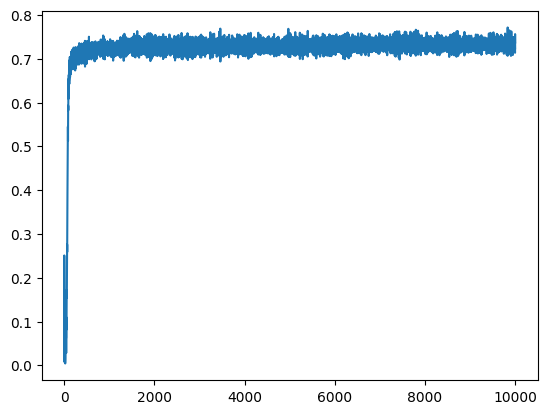

In [717]:
plt.plot(t,rs)

(1.0, 827.4)

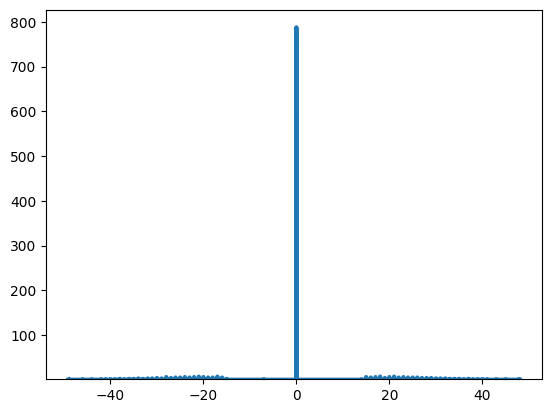

In [750]:
th = ((theta[-1] - theta[-1000] )//(np.pi*2))
c,b = np.histogram(th,bins=5000)
plt.plot(b[1:],c,lw=3)
plt.ylim(1,)

788
0
59
0
0
0
63


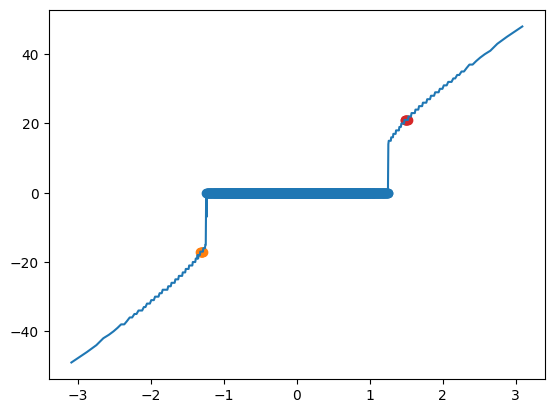

In [736]:
un,ui,uc = np.unique(th,return_index=True,return_counts=True,)
uci = np.argsort(uc)
plt.plot(omega,th)
for i in un[uci][:-8:-1]:
    X, = np.where(th==i)
    th = np.where(np.abs(th-i)<5,i,th)
    plt.scatter(omega[X],th[X],label=f'{i},{len(X)}')
    

    # print(np.unique(np.diff(X),return_counts=True))

# un,ui,uc = np.unique(th,return_index=True,return_counts=True,)
# uct, = np.where(uc>TH)
# un,ui,uc = un[uct],ui[uct],uc[uct]
# uci = np.argsort(uc)

for i in un[uci][:-8:-1]:
    X, = np.where(th==i)
    print(len(X))
    # plt.scatter(X,th[X],label=f'{i},{len(X)}')
    # print(np.unique(np.diff(X),return_counts=True))


In [738]:
for i in un[uci][:-8:-1]:
    X, = np.where(th==i)
    print(i)

0.0
-17.0
-21.0
21.0
18.0
17.0
20.0


In [739]:
c,b = np.histogram(th,bins=3000)


In [740]:
def get_indx(th,rs,N): 
    th = np.where(th>=0,th,th+1)
    th = th/(t[-1] - t[-5000])
    c,b = np.histogram(th,bins=5000)
    c_sort = np.sort(c)[::-1]
    c_3 = np.where(c_sort>3)
    c_arg = np.argsort(c)[::-1]
    b_n0 = b[c_arg[c_3]]
    db = b[1] - b[0]
    gs = {}
    gs['group #'] = []
    gs['group rot'] = []
    gs['group idx'] = []
    if np.mean(rs)>1/np.sqrt(N):
        for b_l in b_n0:
            idx, = np.where((th>=b_l)&(th<=b_l+db))
            gs['group idx'].append(idx)
            gs['group rot'].append(np.mean(th[idx])*(np.pi*2))
            gs['group #'].append(len(idx))
    return pd.DataFrame(gs)


In [741]:
df_g = get_indx(th,rs[-500:],N)

In [742]:
np.mean(rs[-500:]) / (1/np.sqrt(N))

23.209222525733853

# 하고 싶은일
1. 그룹에 대해서 

In [743]:
from scipy.cluster.hierarchy import linkage, fcluster

In [744]:
df_g.iloc[0,1,2].sum()

IndexingError: Too many indexers

In [745]:
df_g['group abs rot2'] = (df_g['group rot']-(df_g['group rot'].iloc[0]+df_g['group rot'].iloc[1])/2).apply(lambda x: np.abs(x))
df_g['group abs rot'] = (df_g['group rot']-(df_g['group rot'].iloc[0])).apply(lambda x: np.abs(x))
# .apply(lambda x: np.abs(x))

In [746]:
from sklearn.cluster import DBSCAN

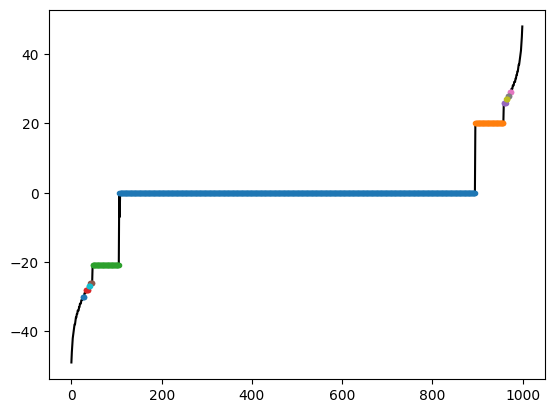

In [749]:
for idx in df_g['group idx']:
    plt.scatter(idx,th[idx],marker='.',zorder=3)
plt.plot(th,color='black')

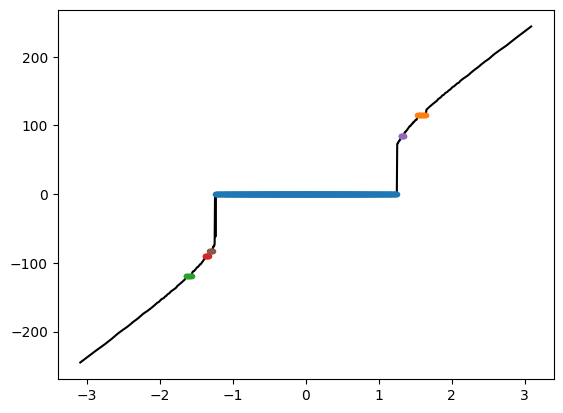

In [733]:
for idx in df_g['group idx']:
    plt.scatter(omega[idx],th[idx],marker='.',zorder=3)
plt.plot(omega,th,color='black')

In [716]:
df_g['group abs rot']

0    0.000000
1    1.445422
2    1.483128
3    1.118631
4    1.030649
5    1.055786
Name: group abs rot, dtype: float64

In [655]:
df_g['group abs rot']

0    0.000000
1    1.646524
2    1.194044
3    1.520835
4    1.520835
5    1.747075
6    1.181475
Name: group abs rot, dtype: float64

In [656]:
np.sort(abs(df_g['group rot']-df_g['group rot'].iloc[0]))

array([0.        , 1.18147513, 1.19404402, 1.52083501, 1.52083501,
       1.64652386, 1.74707493])

In [661]:
df_g.sort_values(by='group abs rot')

,group #,group rot,group idx,group abs rot2,group abs rot
0,879,0.000000,"[61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 7...",0.823262,0.000000
6,4,1.181475,"[940, 941, 942, 943]",2.004737,1.181475
2,6,-1.194044,"[55, 56, 57, 58, 59, 60]",0.370782,1.194044
3,6,-1.520835,"[37, 38, 39, 40, 41, 42]",0.697573,1.520835
4,6,1.520835,"[957, 958, 959, 960, 961, 962]",2.344097,1.520835
1,6,-1.646524,"[30, 31, 32, 33, 34, 35]",0.823262,1.646524
5,5,-1.747075,"[25, 26, 27, 28, 29]",0.923813,1.747075


In [658]:
df_g['group abs rot']

0    0.000000
1    1.646524
2    1.194044
3    1.520835
4    1.520835
5    1.747075
6    1.181475
Name: group abs rot, dtype: float64

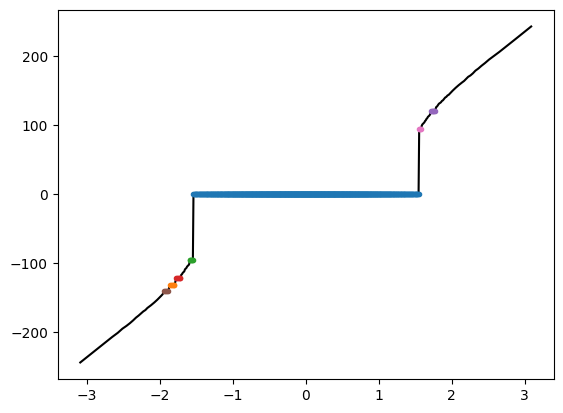

In [659]:

for idx in df_g['group idx']:
    plt.scatter(omega[idx],th[idx],marker='.',zorder=3)
plt.plot(omega,th,color='black')

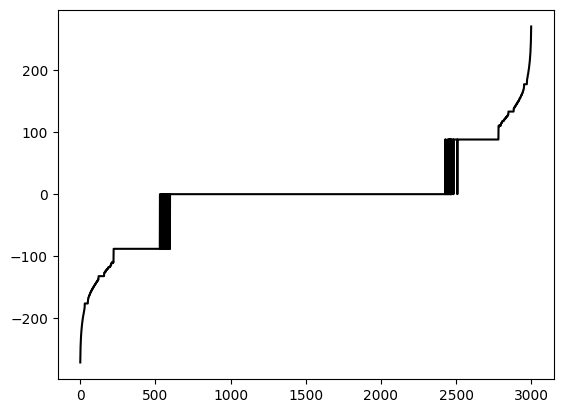

In [59]:
uci = np.argsort(uc)
plt.plot(th,color='black')
for i in un[uci][:-8:-1]:
    X, = np.where(th==i)
    plt.scatter(X,th[X],s=5,zorder=5)
    print(np.unique(np.diff(X),return_counts=True))

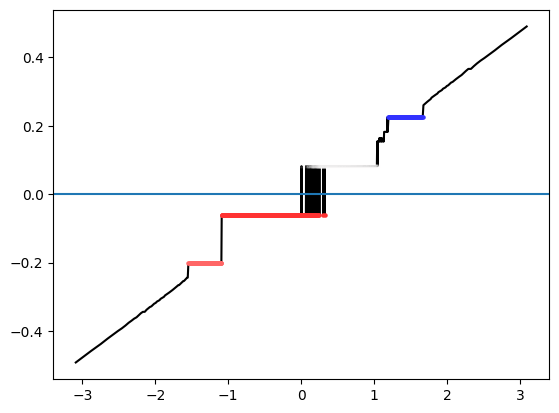

In [445]:
uci = np.argsort(uc)
plt.plot(omega,th/500,color='black')

color = plt.cm.bwr
plt.scatter(omega[G[0,'I']],th[G[0,'I']]/500,s=5,zorder=5,color=color(0.5),alpha=0.1)
plt.scatter(omega[GP[1,'I']],th[GP[1,'I']]/500,s=5,zorder=5,color =color(0.1))
plt.scatter(omega[GM[1,'I']],th[GM[1,'I']]/500,s=5,zorder=5,color =color(1-0.1))
plt.scatter(omega[GP[2,'I']],th[GP[2,'I']]/500,s=5,zorder=5,color =color(0.2))
plt.scatter(omega[GM[2,'I']],th[GM[2,'I']]/500,s=5,zorder=5,color =color(1-0.2))
plt.scatter(omega[GP[3,'I']],th[GP[3,'I']]/500,s=5,zorder=5,color =color(0.3))
plt.scatter(omega[GM[3,'I']],th[GM[3,'I']]/500,s=5,zorder=5,color =color(1-0.3))
plt.scatter(omega[GP[4,'I']],th[GP[4,'I']]/500,s=5,zorder=5,color =color(0.4))
plt.scatter(omega[GM[4,'I']],th[GM[4,'I']]/500,s=5,zorder=5,color =color(1-0.4))
plt.axhline(0)



# plt.scatter(omega[GP[5,'I']],th[GP[5,'I']],s=5,zorder=5,color =color(0.5))
# plt.scatter(omega[GM[5,'I']],th[GM[5,'I']],s=5,zorder=5,color =color(1-0.5))

In [201]:
r = np.abs(np.sum(np.exp(1j*theta[:,]),axis=1)/N)
r0 = np.abs(np.sum(np.exp(1j*theta[:,G[0,'I']]),axis=1)/N)
r1m = np.zeros_like(r0)* np.nan
r1p = np.zeros_like(r0)* np.nan
r2m = np.zeros_like(r0)* np.nan
r2p = np.zeros_like(r0)* np.nan


r1m = np.abs(np.sum(np.exp(1j*theta[:,GM[1,'I']]),axis=1)/N)
r1p = np.abs(np.sum(np.exp(1j*theta[:,GP[1,'I']]),axis=1)/N)
r2m = np.abs(np.sum(np.exp(1j*theta[:,GM[2,'I']]),axis=1)/N)
r2p = np.abs(np.sum(np.exp(1j*theta[:,GP[2,'I']]),axis=1)/N)

In [202]:
RML = np.mean(r[-1000])

In [203]:
RML < np.sqrt(1/N)

True

In [204]:
R = np.abs(np.mean(np.exp(1j*theta[:,]),axis=1))
R0 = np.abs(np.mean(np.exp(1j*theta[:,G[0,'I']]),axis=1))
R1m = np.zeros_like(r0)* np.nan
R1p = np.zeros_like(r0)* np.nan
R2m = np.zeros_like(r0)* np.nan
R2p = np.zeros_like(r0)* np.nan
R1m = np.abs(np.mean(np.exp(1j*theta[:,GM[1,'I']]),axis=1))
R1p = np.abs(np.mean(np.exp(1j*theta[:,GP[1,'I']]),axis=1))
R2m = np.abs(np.mean(np.exp(1j*theta[:,GM[2,'I']]),axis=1))
R2p = np.abs(np.mean(np.exp(1j*theta[:,GP[2,'I']]),axis=1))

In [157]:
R0M = np.array([np.mean(R0[i:i+500]) for i in range(len(t)-500)])
SR = np.array([np.std(R[i:i+500]) for i in range(len(t)-500)])

R1mM = np.array([np.mean(R1m[i:i+500]) for i in range(len(t)-500)])
R1pM = np.array([np.mean(R1p[i:i+500]) for i in range(len(t)-500)])


R2mM = np.array([np.mean(R2m[i:i+500]) for i in range(len(t)-500)])
R2pM = np.array([np.mean(R2p[i:i+500]) for i in range(len(t)-500)])
tmm = np.array([np.mean(t[i:i+500]) for i in range(len(t)- 500)])

In [158]:
r0M = np.array([np.mean(r0[i:i+500]) for i in range(len(t)-500)])
SR = np.array([np.std(r[i:i+500]) for i in range(len(t)-500)])

r1mM = np.array([np.mean(r1m[i:i+500]) for i in range(len(t)-500)])
r1pM = np.array([np.mean(r1p[i:i+500]) for i in range(len(t)-500)])
tmm = np.array([np.mean(t[i:i+500]) for i in range(len(t)- 500)])

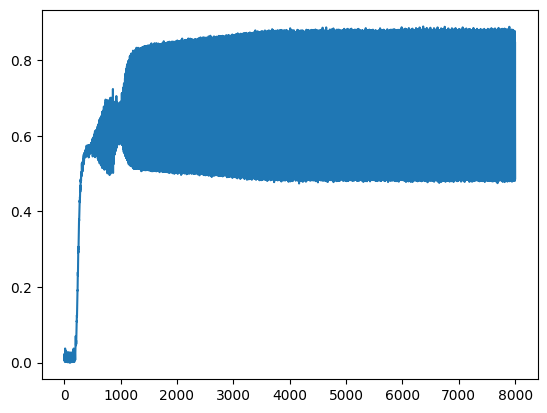

In [159]:
plt.plot(t,R)

In [164]:
T = np.where(R0>0.985)[0][0]

In [165]:
T

9094

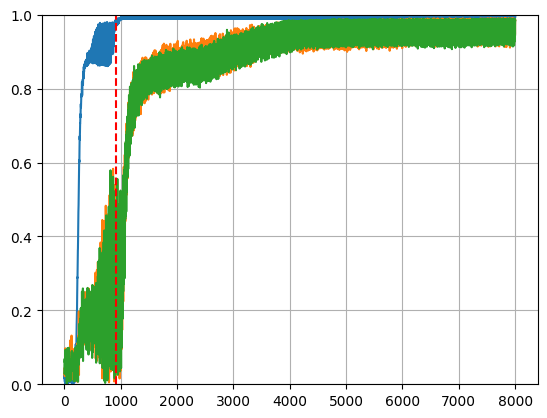

In [166]:
plt.plot(t,np.abs(R0))
# plt.plot(t,np.abs(R))
plt.plot(t,np.abs(R1m))
plt.plot(t,np.abs(R1p))
plt.axvline(t[T],color='red',ls='--')
# plt.xlim(0,2000)
plt.ylim(0,1)
plt.grid()

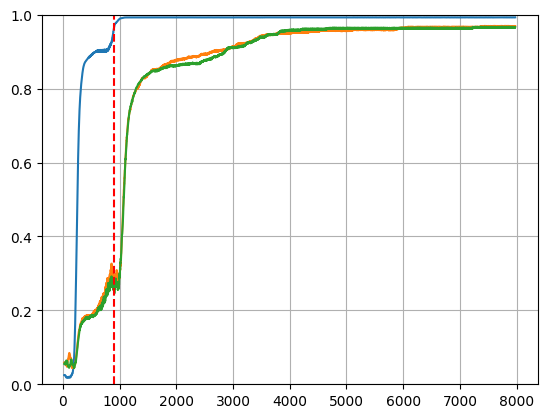

In [167]:
plt.plot(tmm,np.abs(R0M))
plt.plot(tmm,np.abs(R1mM))
plt.plot(tmm,np.abs(R1pM))


# plt.plot(tmm,np.abs(R2mM))
# plt.plot(tmm,np.abs(R2pM))
plt.axvline(t[T],color='red',ls='--')
# plt.xlim(0,2000)
plt.ylim(0,1)
plt.grid()

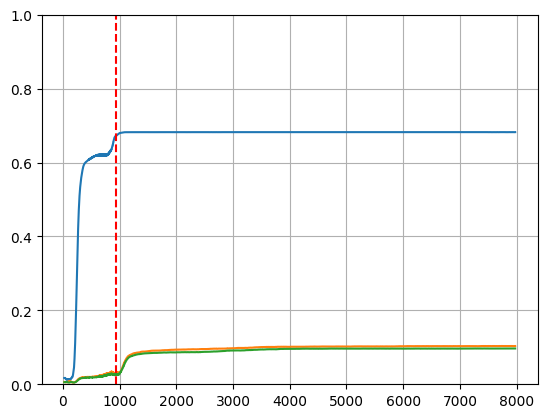

In [168]:
plt.plot(tmm,np.abs(r0M))
plt.plot(tmm,np.abs(r1mM))
plt.plot(tmm,np.abs(r1pM))
plt.axvline(tmm[T],color='red',ls='--')
# plt.xlim(0,2000)
plt.ylim(0,1)
plt.grid()

Text(0.5, 1.0, '$m=8,K=7,N=5000$')

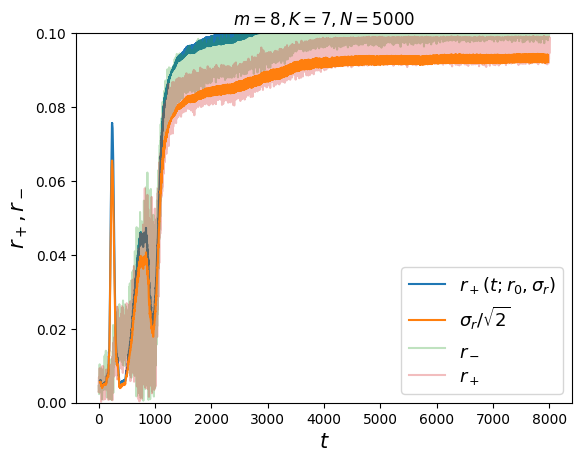

In [169]:
plt.plot(tmm,get_rp(r0M,SR,K,m),label='$r_+(t;r_0,\sigma_r)$')
plt.plot(tmm,SR/np.sqrt(2),zorder=3,label='$\sigma_r/\sqrt{2}$')
plt.plot(t,r1m,alpha=0.3,label='$r_-$')
plt.plot(t,r1p,alpha=0.3,label='$r_+$')
plt.ylim(0,0.1)
plt.legend(fontsize=13)
plt.xlabel('$t$',fontsize=15)
plt.ylabel('$r_+, r_-$',fontsize=15)
plt.title(f'$m={m},K={K},N={N}$')
# plt.plot(t,r0)


Text(0.5, 1.0, '$m=8,K=7,N=5000$')

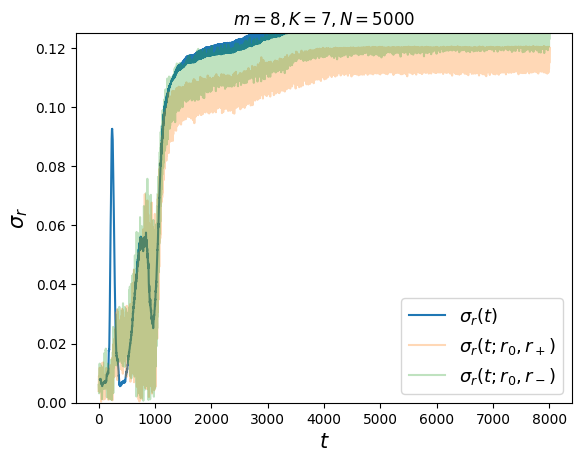

In [170]:
plt.plot(tmm,SR,label=r'$\sigma_r(t)$')
# plt.plot(tmm,get_Sig_r(r0M,r1mM,K,m))
# plt.plot(tmm,get_Sig_r(r0M,r1pM,K,m))
plt.plot(t,get_Sig_r(r0,r1p,K,m),alpha=0.3,label=r'$\sigma_r(t;r_0,r_+)$')
plt.plot(t,get_Sig_r(r0,r1m,K,m),alpha=0.3,label=r'$\sigma_r(t;r_0,r_-)$')
plt.legend(fontsize=13)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel('$\sigma_r$',fontsize=15)

plt.ylim(0,0.125)
plt.title(f'$m={m},K={K},N={N}$')

NameError: name 'T' is not defined

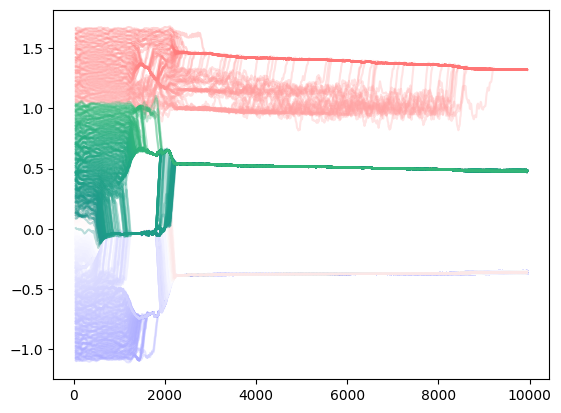

In [372]:

t_avg =  np.array([np.mean(t[i:i+1000]) for i in range(0,len(t)-1000,100)])
avg_dtheta = np.array([np.mean(dtheta[i:i+1000],axis=0) for i in range(0,len(t)-1000,100)])
# plt.plot(t_avg,avg_dtheta[:,G[0,'I']],color='black')
G1 = np.array([*GP[1,'I'],*GM[1,'I']])
n_omega = (omega - omega[0])/(omega[-1]-omega[0])
bwr = plt.cm.bwr(n_omega[G1])
virdis = plt.cm.viridis(n_omega[G[0,'I']])



ls = plt.plot(t_avg,avg_dtheta[:,G1],alpha=0.3)
ls2 = plt.plot(t_avg,avg_dtheta[:,G[0,'I']],alpha=0.3)
for l,c in zip(ls,bwr):
    l.set_color(c)

for l,c in zip(ls2,virdis):
    l.set_color(c)
# plt.plot(t_avg,avg_dtheta[:,],color='red',alpha=0.3)




plt.axvline(t[T],color='red',ls='--')
plt.xlim(0,2000)

In [219]:
ROT = (theta[2000::1]-theta[:-2000:1])//(np.pi*2)

In [220]:
GP[1,'I']

array([2427, 2432, 2445, 2447, 2453, 2454, 2456, 2457, 2458, 2462, 2464,
       2466, 2467, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481,
       2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493,
       2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504,
       2505, 2506, 2507, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516,
       2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527,
       2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538,
       2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549,
       2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560,
       2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571,
       2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582,
       2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593,
       2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604,
       2605, 2606, 2607, 2608, 2609, 2610, 2611, 26

In [176]:
ROT[-1,G[0,'I']]

array([0., 0., 0., ..., 0., 0., 0.])

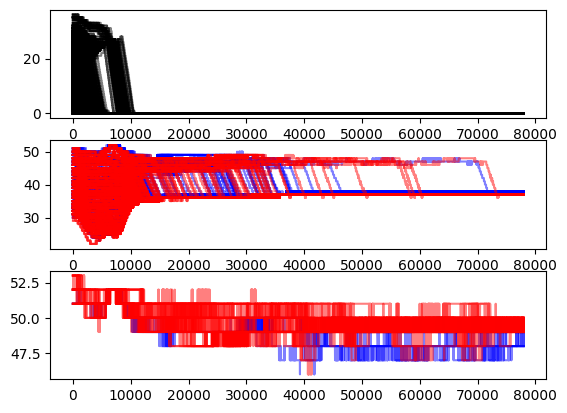

In [177]:
plt.subplot(311)
plt.plot(abs(ROT[:,G[0,'I']]),color='black',alpha=0.5)

plt.subplot(312)
plt.plot(ROT[:,GP[1,'I']],color='blue',alpha=0.5)
plt.plot(np.abs(ROT[:,GM[1,'I']])-1,color='red',alpha=0.5)

plt.subplot(313)
plt.plot(ROT[:,GP[2,'I']],color='blue',alpha=0.5)
plt.plot(np.abs(ROT[:,GM[2,'I']])-1,color='red',alpha=0.5)




In [227]:
a,b = np.unique(ROT[-1],return_counts=True)

b_5, = np.where(b>5)
B5 = b[b_5]
A5 = a[b_5]
sort_A5 = np.sort()


# a[np.argsort(b)[::-1]],np.sort(b)[::-1]

(array([   0.,  -36.,   35.,  -53.,   53.,  -71.,   70.,  -47.,   44.,
          47.,  -49.,  -45.,   48.,  -50.,  -60.,   49.,   50.,   55.,
          58.,  -57.,   57.,  -58.,   46.,   56.,  -55.,  -62.,  -51.,
          62.,  -56.,   59.,   51.,  -44.,   61.,   60.,  -67.,  -65.,
         -64.,  -63.,  -61.,  -59.,  -46.,   64.,   45.,  -52.,   63.,
          65.,   66.,   67.,  -48.,   54.,   74.,   81.,  -66.,   79.,
          52.,  -82.,  -75.,  -77.,  -79.,   43.,   77.,  -80.,   76.,
          75.,  -76.,  -90.,  -81.,  -78.,  -74.,  -89.,  -84.,  -88.,
         -87.,  -86.,  -85., -103.,  -73.,  -83.,  -92.,  -99.,  -96.,
         -94.,  108.,  -72.,  -69.,   98.,   95.,   93.,   91.,   89.,
          88.,   87.,   86.,   85.,   84.,   83.,   82.,   80.,   78.,
          73.,   71.,   69.,   68.,  102.,  -43.,  -68., -109.]),
 array([1906,  334,  320,   29,   26,   20,   18,   16,   13,   11,   10,
          10,    9,    8,    8,    8,    8,    7,    7,    7,    7,    7,
     

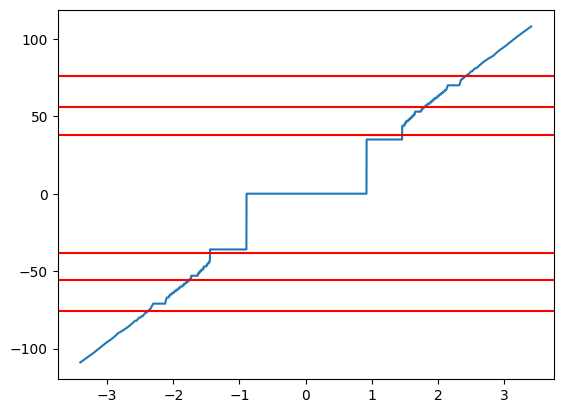

In [226]:
plt.plot(omega,np.sort(ROT[-1]))
# plt.plot(omega,ROT[-1])
plt.axhline(38,color='red')
plt.axhline(56,color='red')
plt.axhline(76,color='red')


plt.axhline(-38,color='red')
plt.axhline(-56,color='red')
plt.axhline(-76,color='red')

In [183]:
np.sort(b)[::-1]

array([3436,  534,  501,   60,   52,   35,   30,   20,   19,   14,   10,
         10,   10,    9,    9,    9,    8,    8,    8,    8,    8,    7,
          7,    7,    7,    7,    7,    6,    6,    6,    6,    6,    6,
          5,    5,    5,    5,    5,    4,    4,    4,    4,    4,    3,
          3,    3,    3,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    2,    2,    2,    2,    2,    2,    2,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1])

In [93]:
M_list = []
for i in range(5000):
    x, = np.where(ROT[i] == 0)
    M_list.append(len(x))

In [51]:
t.shape

(50000,)

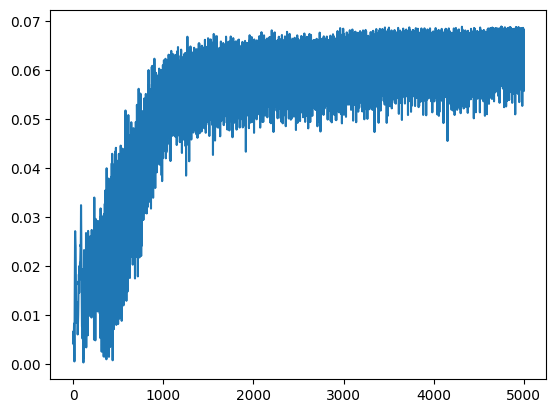

In [55]:
plt.plot(t,r1p)

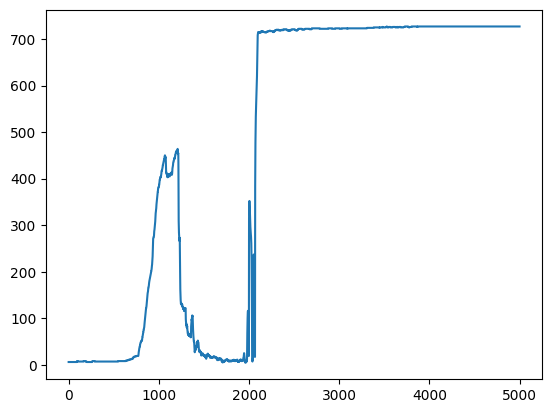

In [52]:
plt.plot(M_list)

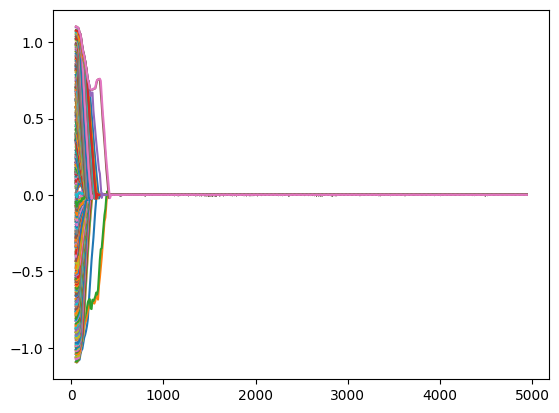

In [30]:

plt.plot(t_avg,avg_dtheta[:,G[0,'I']])


In [ ]:
# sigs = get_Sig_r(np.abs(r0),np.abs(r1p),K,m)
sigs = get_Sig_r(np.abs(r0),np.abs(r1m),K,m)

In [ ]:
avg = 500
t_ = t[avg:]
sigs_wr = np.array([np.std(np.abs(r[i:i+avg])) for i in range(len(t)-avg)])
avg_wr = np.array([np.average(np.abs(r[i:i+avg])) for i in range(len(t)-avg)])

In [ ]:
m

6

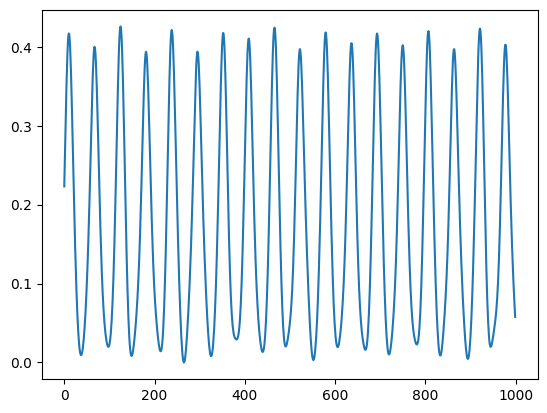

In [427]:
plt.plot(np.abs(r[-1000:]) - np.min(np.abs(r[-1000:])))

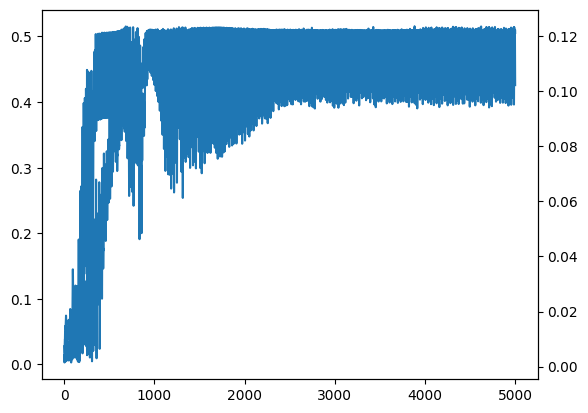

In [368]:
# plt.plot(t,np.abs(r))
plt.plot(t,np.abs(r0))
plt.twinx()
plt.plot(t,np.abs(r1m))

In [613]:
plt.plot(t_,get_rp(np.abs(r0[avg:]),sigs_wr,K,m))
plt.plot(t,np.abs(r1m))

ValueError: operands could not be broadcast together with shapes (99500,) (49500,) 

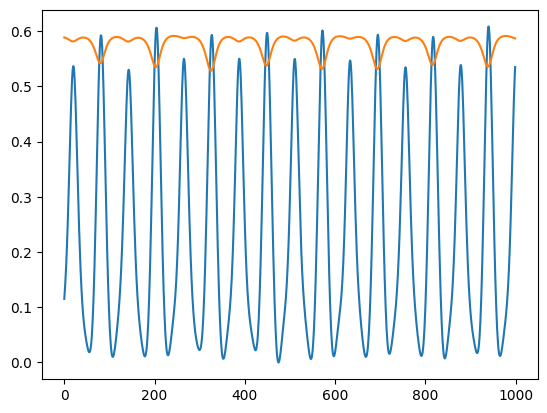

In [753]:
plt.plot(np.abs(r[-1000:]) - np.min(np.abs(r[-1000:])))
plt.plot(2*(np.abs(r1m[-1000:])+np.abs(+r1p[-1000:])))

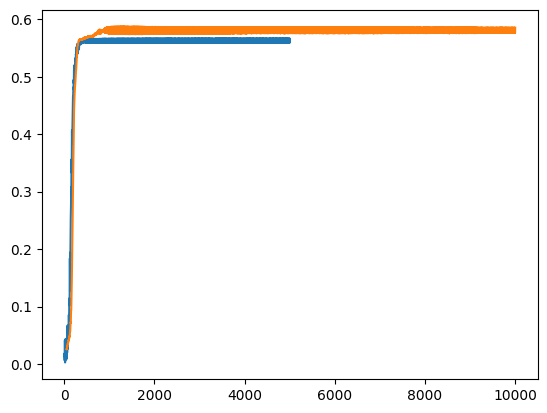

In [754]:
plt.plot(t,np.abs(r0))
plt.plot(t_,avg_wr)
# plt.xlim(0,500)


[]

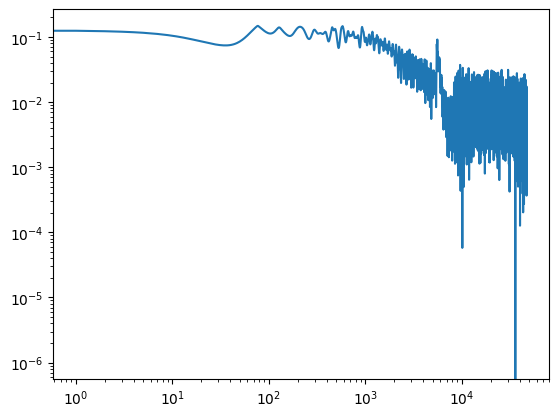

In [436]:
plt.plot(np.max(sigs) - sigs[3000:])

# plt.plot(t_,sigs_wr)
plt.loglog()
# plt.xlim(0,2000)  


$\Omega_+ = \dfrac{4}{\pi}\sqrt{\dfrac{Kr_0}{m}} - 0.3056\sqrt{\dfrac{1}{Kr_0m^3}}$

In [164]:
OPs = get_OP(np.abs(r0),K,m)


In [165]:
dtheta.shape

(50000, 3000)

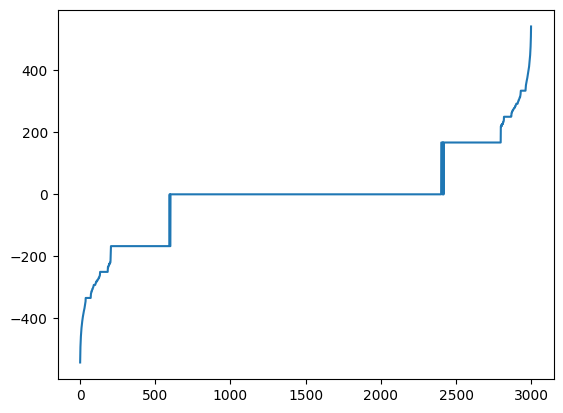

In [610]:
plt.plot((theta[-1] - theta[-10000])//(np.pi*2))

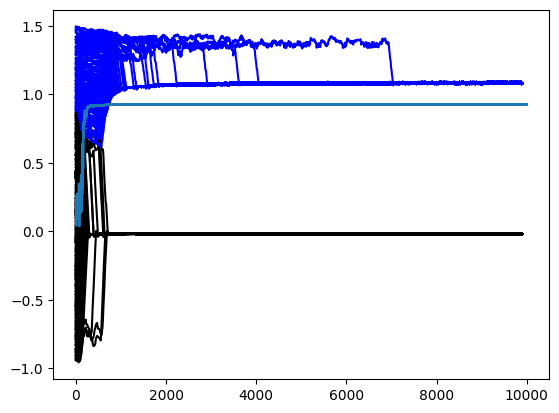

In [441]:
plt.plot(t[:-1000:100],avg_dtheta[:,G[0,'I']],alpha=1,color='black')
plt.plot(t[:-1000:100],avg_dtheta[:,GP[1,'I']],alpha=1,color='blue')
plt.plot(t,get_OP(np.abs(r0),K,m))

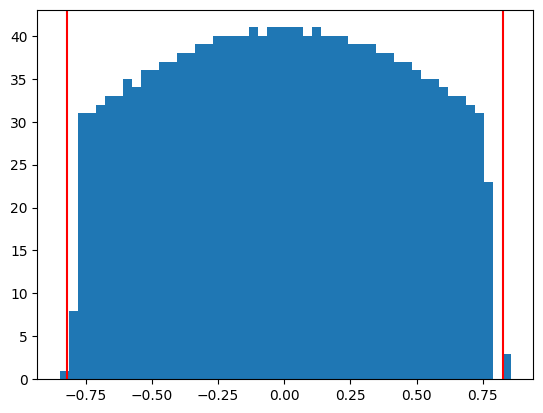

In [755]:
g0 = (np.min(omega[G[0,'I']]) + np.max(omega[G[0,'I']]))/2
plt.hist(omega[G[0,'I']],bins=50);
plt.axvline(get_OP(np.abs(r0[-1])+g0,K,m),color='red')
plt.axvline(-get_OP(np.abs(r0[-1])-g0,K,m),color='red')

## $P_{ij}$ Local order parameter check

In [1008]:
Tw = 100

P0j = np.abs(np.mean([np.exp(1j*theta[i].reshape(1,-1) - 1j*theta[i].reshape(1,-1).T) for i in range(Tw)],axis=0))

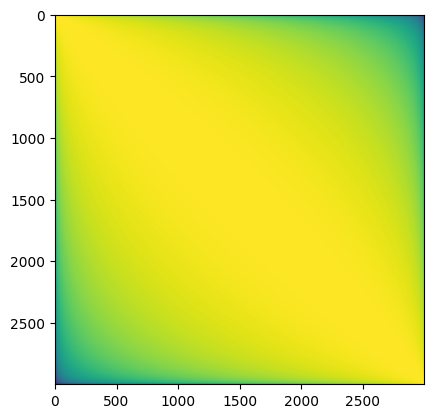

In [1010]:
plt.imshow(P0j)

In [1000]:
# P0j = np.abs(np.mean([np.sin(theta[i] - theta[i,N//2]) for i in range(Tw)],axis=0))
P0j.shape

(1, 3000)

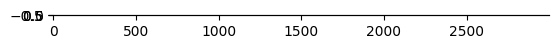

In [1001]:
plt.imshow(P0j)

In [970]:
theta[:10].shape

(10, 3000)